#CSV analyzer for The Financial Times

In [1]:
import math
import pickle
from datetime import datetime

import blaze
import matplotlib
import pandas as pd
from dateutil.relativedelta import relativedelta
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pymongo import MongoClient

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams['figure.max_open_warning'] = 300

In [4]:
import seaborn as sns

In [5]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len/2-1):-(window_len/2)]


## Data

In [6]:
total_data = pd.read_csv('../nytimes/ft_rows.csv')

In [7]:
total_data.count()

article_id       166023
pub_date         166023
public_url       166023
web_url          166023
term_category    166023
term             166023
sentence         166023
dtype: int64

In [8]:
total_data_dedup = total_data.drop_duplicates()

In [9]:
total_data_dedup.count()

article_id       166017
pub_date         166017
public_url       166017
web_url          166017
term_category    166017
term             166017
sentence         166017
dtype: int64

In [10]:
list(total_data_dedup.term.value_counts().items())

[('at&t', 57517),
 ('executive', 29844),
 ('Become Inc', 11231),
 ('manager', 8375),
 ('Google', 6497),
 ('apple', 5251),
 ('microsoft', 4724),
 ('founder', 3945),
 ('general motors', 2814),
 ('facebook', 2590),
 ('ford', 2574),
 ('entrepreneur', 2342),
 ('boeing', 1857),
 ('intel corporation', 1731),
 ('Signal', 1699),
 ('samsung', 1648),
 ('wal-mart', 1506),
 ('amazon.com', 1423),
 ('twitter', 1381),
 ('general electric', 1140),
 ('visa', 1031),
 ('exxon', 965),
 ('ebay', 910),
 ('blackrock', 760),
 ('coca-cola company', 751),
 ('Nordic', 736),
 ('chevron', 718),
 ('Indeed', 695),
 ('3m company', 594),
 ('walt disney company', 533),
 ('Voices.com', 494),
 ('procter & gamble', 430),
 ('pepsico', 402),
 ('berkshire hathaway', 394),
 ('caterpillar', 380),
 ('nike', 380),
 ('alcoa', 373),
 ('halliburton company', 324),
 ('dow chemical', 324),
 ('netflix', 294),
 ('conocophillips', 264),
 ('Exec', 262),
 ('morgan chase', 253),
 ('mckinsey & company', 248),
 ('johnson & johnson', 244),
 ('

In [11]:
# Remove
remove_list = ['Become Inc', 'Indeed', 'at&t', 'Signal']

In [12]:
for term in remove_list:
    total_data_dedup = total_data_dedup[total_data_dedup['term'] != term]

In [13]:
total_data_dedup.count()

article_id       94875
pub_date         94875
public_url       94875
web_url          94875
term_category    94875
term             94875
sentence         94875
dtype: int64

In [14]:
total_grouped = total_data_dedup.groupby(['article_id', 'term'])['sentence']

In [15]:
def indexes_to_delete(series):
    del_index_list = []
    for i1, s1 in series.items():
        for i2, s2 in series.items():
            if i1 != i2 and s1 in s2:
                del_index_list.append(i1)
                break
    return str(del_index_list)

In [16]:
grouped_indexes = total_grouped.aggregate({'indexes_to_delete': indexes_to_delete})

In [17]:
remove_index_list = list(set(
    [index for index_list in grouped_indexes['indexes_to_delete'] for index in eval(index_list)]
))

In [18]:
data = total_data_dedup.drop(remove_index_list)

In [19]:
data.count()

article_id       94618
pub_date         94618
public_url       94618
web_url          94618
term_category    94618
term             94618
sentence         94618
dtype: int64

In [20]:
# df = pd.DataFrame([
#                 [1, 'hola', 'Hola mundo'],         # 0
#                 [1, 'nada', 'Nada que ver'],       # 1
#                 [1, 'hola', 'Hola mundo que tal'], # 2
#                 [1, 'hola', 'Hola'],               # 3
#                 [2, 'hola', 'Hola mundo'],         # 4
#                 [2, 'adios', 'Adios'],             # 5
#                 [3, 'adios', 'Adios'],             # 6
#                ], columns=['article_id', 'term', 'sentence'])
# # g = df.groupby(['article_id', 'term'])['sentence'].aggregate({'indexes_to_delete': indexes_to_delete})
# # l = list(set(
# #     [index for index_list in g['indexes_to_delete'] for index in eval(index_list)]
# # ))
# # df2 = df.drop(l)
# dd = blaze.Data(df)

In [21]:
# blaze.by(blaze.merge(dd.article_id, dd.term),
#          total=dd.article_id.count()
#         )

In [22]:
# Change categories: ebay; executive, manager; entrepreneur, founder, new venture, startup

data.ix[data.term == 'ebay', 'term_category'] = 2

for term in ['executive', 'manager']:
    data.ix[data.term == term, 'term_category'] = 11

for term in ['entrepreneur', 'founder', 'new venture', 'startup']:
    data.ix[data.term == term, 'term_category'] = 12

In [23]:
# Total number of articles
data.article_id.value_counts().count()

71053

In [24]:
# Total number of terms
data.term.value_counts().count()

119

In [25]:
# Total number of sentences
data.sentence.value_counts().count()

79212

In [26]:
data.to_csv('../nytimes/ft_curated_data.csv')

## Classifier

In [28]:
# ________________________________________________________________________________
# Training: NC metric='euclidean' shrink_threshold=None use_idf=True ngram_range=(1, 2) random_state=62
# Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
#         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
#         lowercase=True, max_df=1.0, max_features=None, min_df=1,
#         ngram_range=(1, 2), preprocessor=None, stop_words=None,
#         strip...inear_tf=False, use_idf=True)), ('clf', NearestCentroid(metric='euclidean', shrink_threshold=None))])
# train time: 0.838s
# test time:  0.097s
# accuracy:   0.716
# matthews_corrcoef:   0.397
# classification report:
#              precision    recall  f1-score   support

#         neg       0.61      0.64      0.63       228
#         pos       0.79      0.76      0.77       391

# avg / total       0.72      0.72      0.72       619

# confusion matrix:
# [[147  81]
#  [ 95 296]]


In [29]:
with open('sentiment/pipeline_nc.pickle', 'rb') as be_file:
    be = pickle.load(be_file)

In [30]:
be.predict(['My puppy is cute.', 'People die in war.', 'I love my family.'])

array(['pos', 'neg', 'pos'], dtype=object)

In [32]:
# 8 csv files previously built on another machine. Sentiment included.
data_blaze = blaze.Data('../nytimes/ft_data_*.csv', delimiter=',')

In [33]:
# sentiment_data_ind = blaze.odo(data_blaze, pd.DataFrame)
# sentiment_data = sentiment_data_ind.drop('Unnamed: 0', axis=1) #comentar esta linea
sentiment_data = blaze.odo(data_blaze, pd.DataFrame)

In [34]:
# Delete startup
sentiment_data = sentiment_data[sentiment_data.term != 'startup']

In [35]:
# Total number of articles
sentiment_data.article_id.value_counts().count()

71027

In [36]:
# Total number of terms
sentiment_data.term.value_counts().count()

118

In [37]:
# Total number of sentences
sentiment_data.sentence.value_counts().count()

79177

In [15]:
# sentiments_df = blaze.odo(data_blaze.sentence.map(lambda x: be.predict([x])[0], '?string'), pd.DataFrame)

In [16]:
# def split_dataframe(df, n):
#     d = {}
#     length = len(df)
#     chunk_size = math.ceil(length / n)
#     n_max = math.ceil(length / chunk_size)
#     for i in range(min(n, n_max)):
#         d[i] = df[chunk_size * i: chunk_size * (i + 1)]
#     return d

In [17]:
# def analyze_sentiment(df, i):
#     df['sentiment'] = df.sentence.map(lambda x: be.predict([x])[0])
#     df.to_csv('../nytimes/data_{}.csv'.format(i))
#     print('DataFrame saved in data_{}.csv'.format(i))

In [18]:
# N = 8
# data_dict = split_dataframe(data, N)
# # for i in range(N):
# #     analyze_sentiment(data_dict[i], i)
# Parallel(n_jobs=8)(delayed(analyze_sentiment)(data_dict[i], i) for i in range(N))

In [38]:
def diff_month(d1, d2):
    return (d2.year - d1.year) * 12 + d2.month - d1.month

# assert diff_month(datetime(2010,9,1), datetime(2010,10,1)) == 1
# assert diff_month(datetime(2009,10,1), datetime(2010,10,1)) == 12
# assert diff_month(datetime(2009,11,1), datetime(2010,10,1)) == 11
# assert diff_month(datetime(2009,8,1), datetime(2010,10,1)) == 14

In [39]:
sentiment_data['n_month'] = sentiment_data.pub_date.apply(lambda x: diff_month(datetime(1999, 1, 1), x.date()))

In [40]:
data2 = blaze.Data(sentiment_data)

In [41]:
blaze.by(data2.term_category,
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

,term_category,amount_neg,amount_pos,total_amount
0,2,13194,32009,45203
1,3,1131,3652,4783
2,11,16061,22137,38198
3,12,928,5461,6389


In [42]:
# Old classifier --> more positive

# blaze.by(data2.term_category,
#    total_amount=data2.sentiment.count(),
#    amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
#    amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
# )

#  	term_category 	amount_neg 	amount_pos 	total_amount
# 0 	2 	106075 	251088 	357163
# 1 	3 	18546 	62625 	81171
# 2 	11 	206396 	200361 	406757
# 3 	12 	9900 	79663 	89563

## Visualizations

In [43]:
grouped_by_category = blaze.by(blaze.merge(data2.term_category, data2.n_month),
    total_amount=data2.sentiment.count(),
    amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
    amount_neg=data2[data2.sentiment == 'neg'].sentiment.count(),
)

grouped_by_term = blaze.by(blaze.merge(data2.term, data2.n_month),
   total_amount=data2.sentiment.count(),
   amount_pos=data2[data2.sentiment == 'pos'].sentiment.count(),
   amount_neg=data2[data2.sentiment == 'neg'].sentiment.count()
)

In [44]:
grouped_by_category

,term_category,n_month,amount_neg,amount_pos,total_amount
0,2,62,0,1,1
1,2,63,6,14,20
2,2,64,0,1,1
3,2,65,63,119,182
4,2,66,72,203,275
5,2,67,128,256,384
6,2,68,108,295,403
7,2,69,140,312,452
8,2,70,124,253,377
9,2,71,119,204,323


In [45]:
def plot(term_list=None, same=False, info='total', category_list=None, figsize=(16, 8), window_len=20, window='hanning'):
    if term_list and not same:
        for term in term_list:
            df = blaze.odo(grouped_by_term[grouped_by_term.term == term], pd.DataFrame)
            df.set_index('n_month', inplace=True)
            df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
            df['pos_rate'] = df['amount_pos'] / df['total_amount']
            y1_df = df[['total_amount', 'amount_pos', 'amount_neg']]
            y1_df.plot(title=term, figsize=figsize)
            y2 = smooth(
                    df['pos_rate'].values,
                    window_len=window_len,
                    window=window
            )
            y2_df = pd.DataFrame(y2, columns=['pos_rate'], index=df.index)
            y2_df.plot(title=term, ylim=[0, 1], color='green', figsize=figsize)
    elif term_list and same:
        ax = plt.figure(figsize=figsize).add_subplot(1, 1, 1)
        for term in term_list:
            df = blaze.odo(grouped_by_term[grouped_by_term.term == term], pd.DataFrame)
            df.set_index('n_month', inplace=True)
            df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
            df['pos_rate'] = df['amount_pos'] / df['total_amount']
            if info == 'total':
                y = smooth(
                    df['total_amount'].values,
                    window_len=window_len,
                    window=window
                )
                y_df = pd.DataFrame(y, columns=['total_amount'], index=df.index)
                y_df.plot(title='All together', figsize=figsize, ax=ax)
            else:
                y = smooth(
                    df['pos_rate'].values,
                    window_len=window_len,
                    window=window
                )
                y_df = pd.DataFrame(y, columns=['pos_rate'], index=df.index)
                y_df.plot(title='All together', ylim=[0, 1], figsize=figsize, ax=ax)
        ax.legend(term_list)
    elif category_list:
        category_dict = {
            11: 'executive/manager',
            12: 'entrepreneur/founder/new venture',
            2: 'big companies',
            3: 'new companies',
        }
        if not same:
            for category in category_list:
                df = blaze.odo(grouped_by_category[grouped_by_category.term_category == category], pd.DataFrame)
                df.set_index('n_month', inplace=True)
                df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
                df['pos_rate'] = df['amount_pos'] / df['total_amount']
                y1_df = df[['total_amount', 'amount_pos', 'amount_neg']]
                y1_df.plot(title=category_dict[category], figsize=figsize)
        else:
            ax = plt.figure(figsize=figsize).add_subplot(1, 1, 1)
            for category in category_list:
                df = blaze.odo(grouped_by_category[grouped_by_category.term_category == category], pd.DataFrame)
                df.set_index('n_month', inplace=True)
                df.index = [datetime.strptime("1999-01-01", "%Y-%m-%d") + relativedelta(months=i) for i in df.index]
                df['pos_rate'] = df['amount_pos'] / df['total_amount']
                y2 = smooth(
                        df['pos_rate'].values,
                        window_len=window_len,
                        window=window
                )
                y2_df = pd.DataFrame(y2, columns=['pos_rate'], index=df.index)
                y2_df.plot(title='All together', ylim=[0, 1], figsize=figsize, ax=ax)
            ax.legend(['new companies', 'big companies', 'entrepreneur/founder', 'executive/manager'])

#Images

##Fig.1 Distribution of sentences by category over the period 1999 to 2014

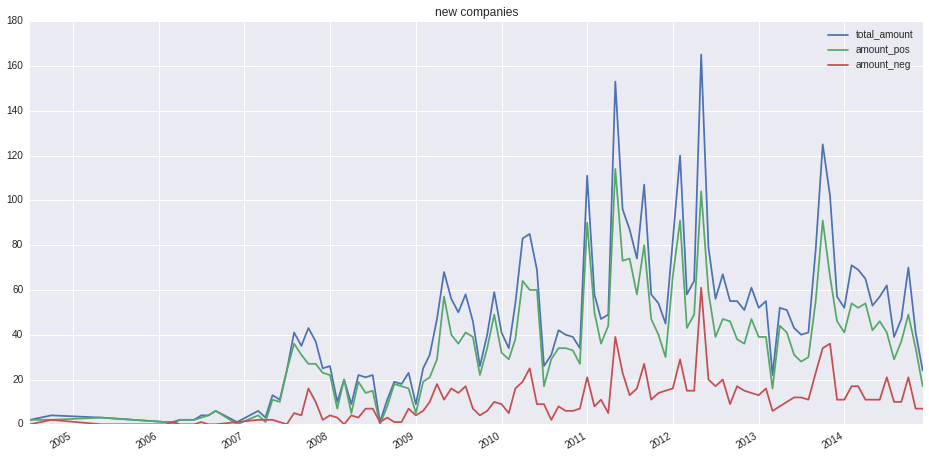

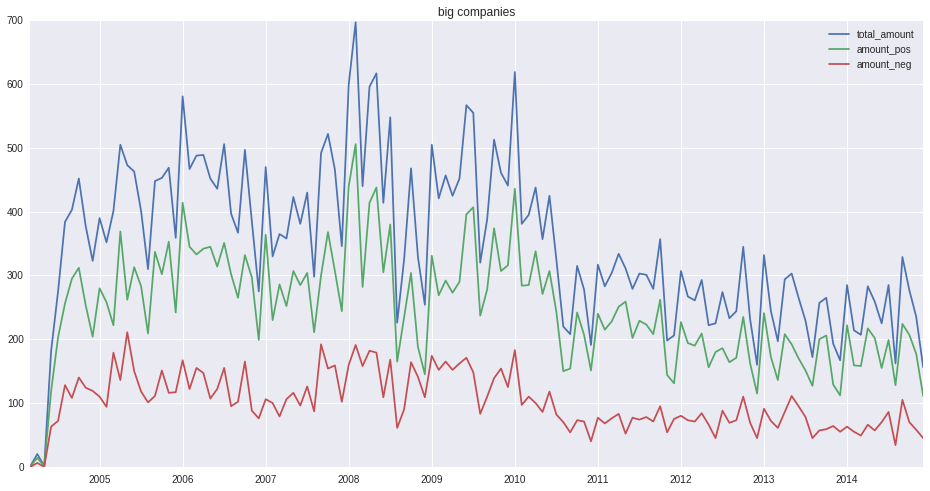

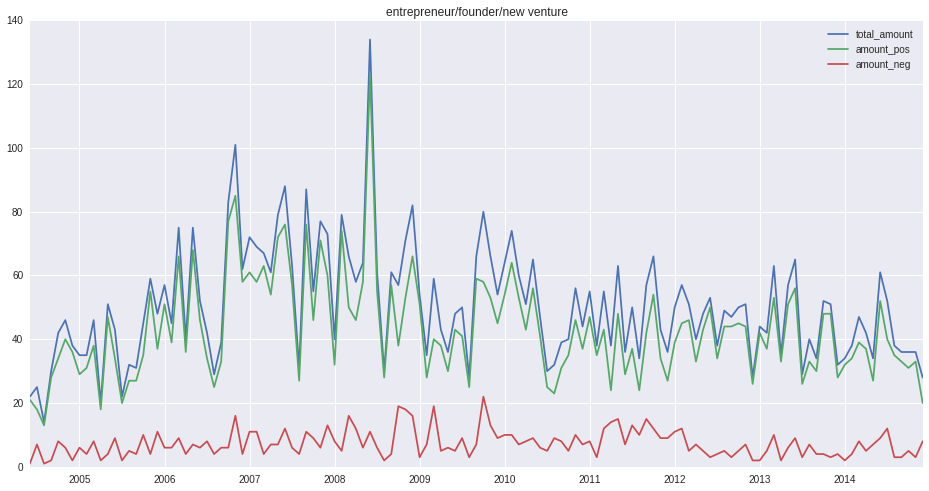

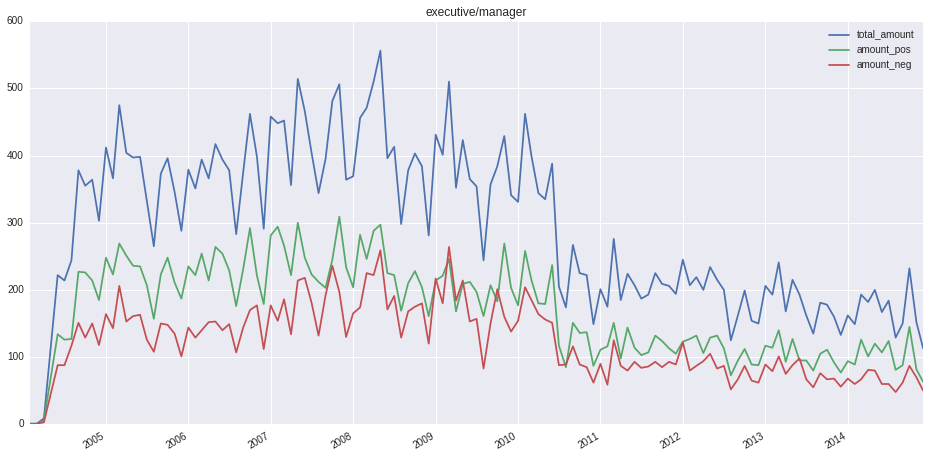

In [46]:
plot(category_list=[3,2, 12,11], info='total', same=False)

##Fig.2 Positive rate of sentences by category over the period 1999 to 2014

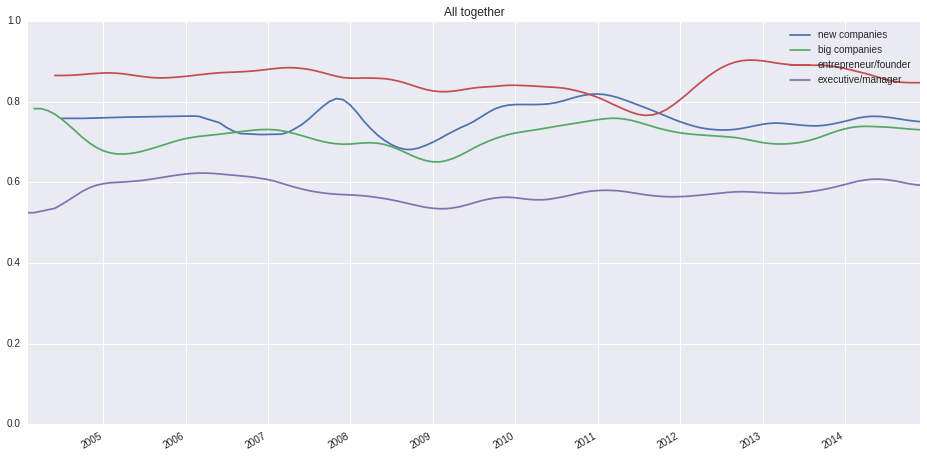

In [47]:
plot(category_list=[3,2, 12,11], info='pos_rate', same=True)

##Fig.3 Distribution of sentences by profession over the period 1999 to 2014

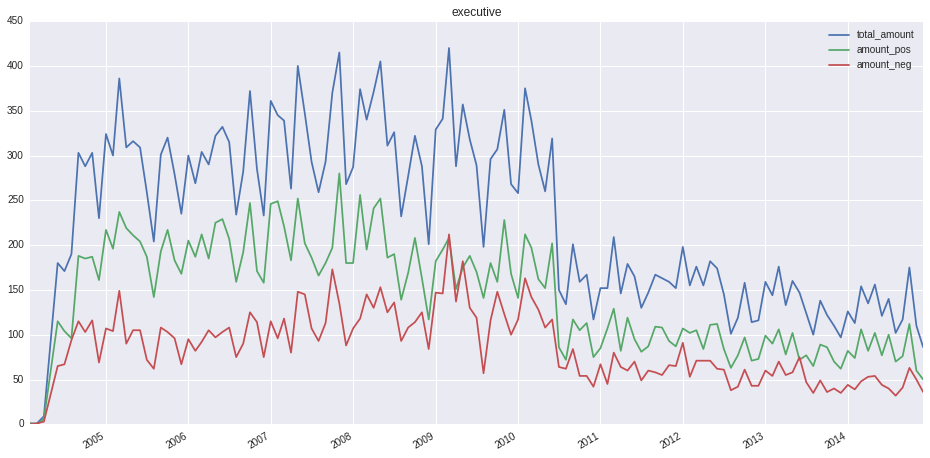

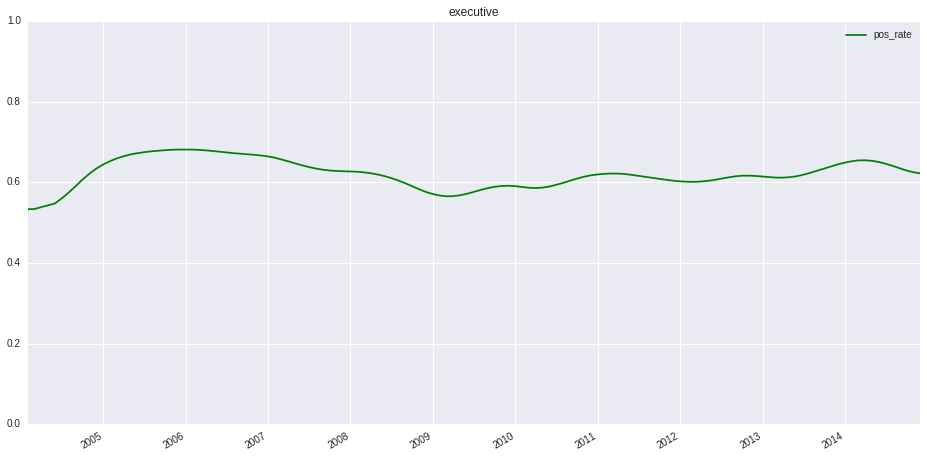

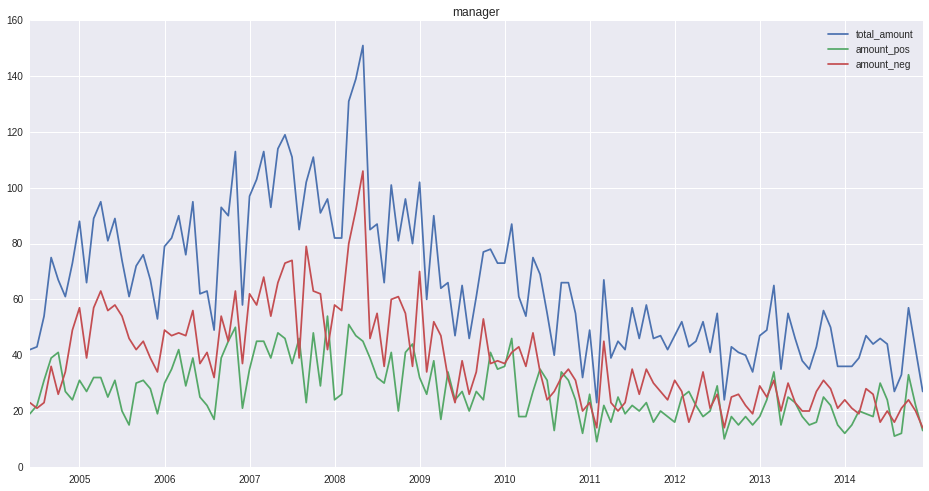

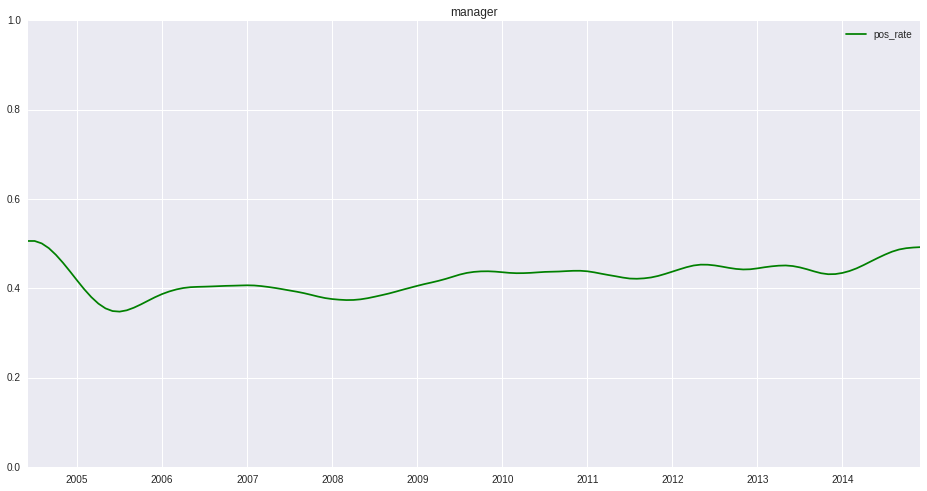

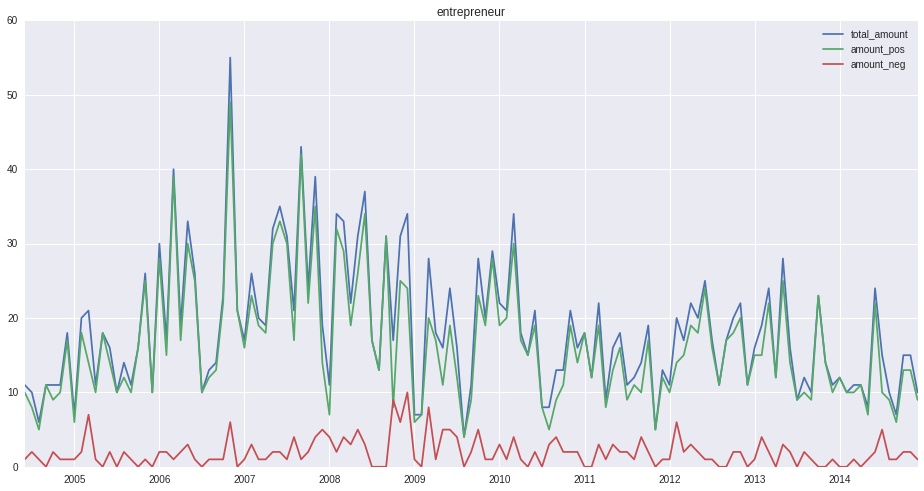

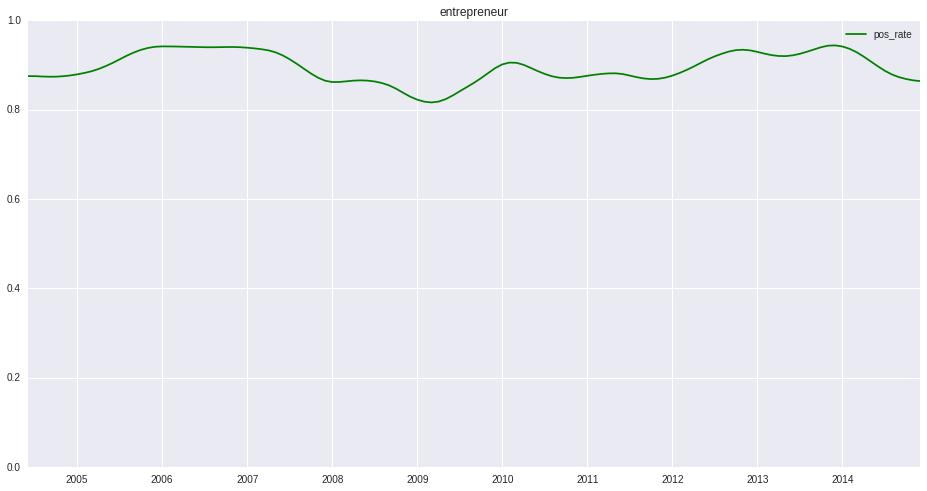

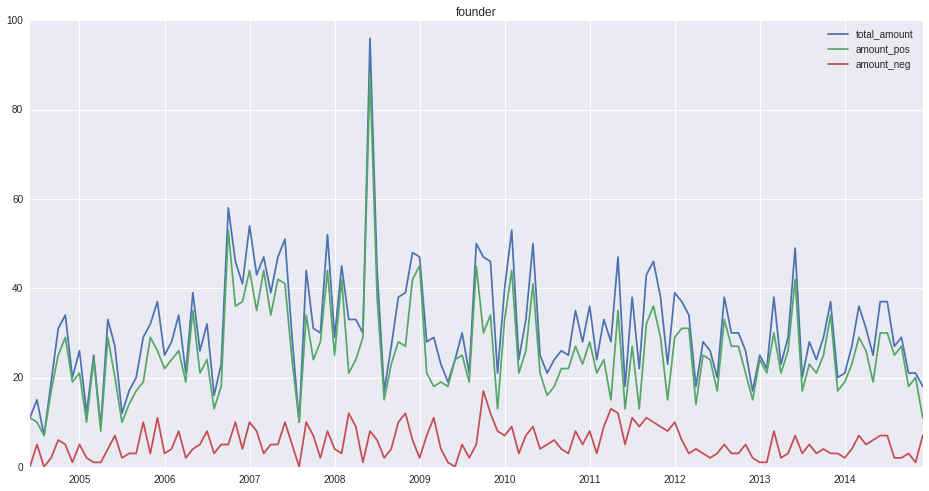

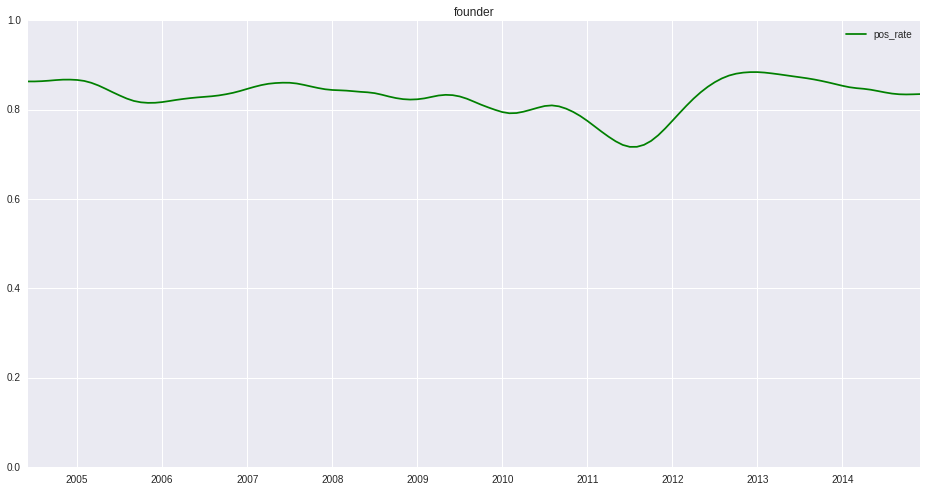

In [48]:
plot(term_list=['executive', 'manager', 'entrepreneur', 'founder'], info='total', same=False)

##Fig.4 Positive rate of sentences by profession over the period 1999 to 2014

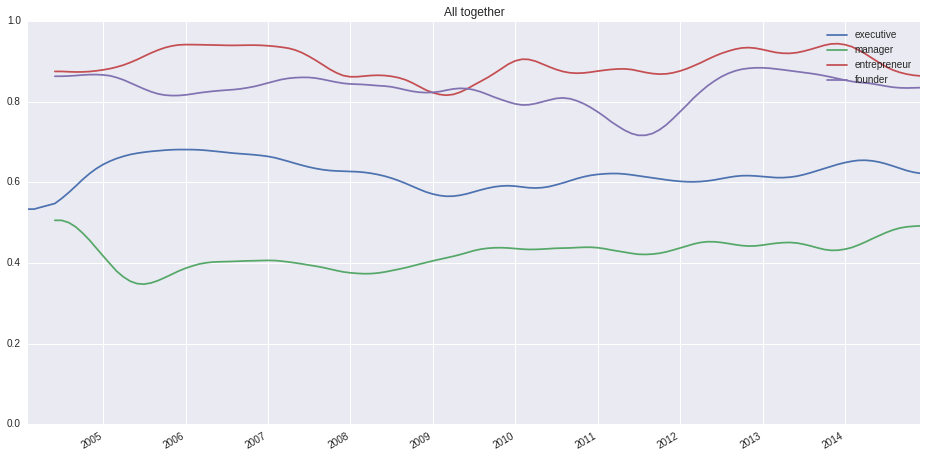

In [49]:
plot(term_list=['executive', 'manager', 'entrepreneur', 'founder'], info='pos_rate', same=True)

##Fig.5 Distribution of sentences for big companies over the period 1999 to 2014

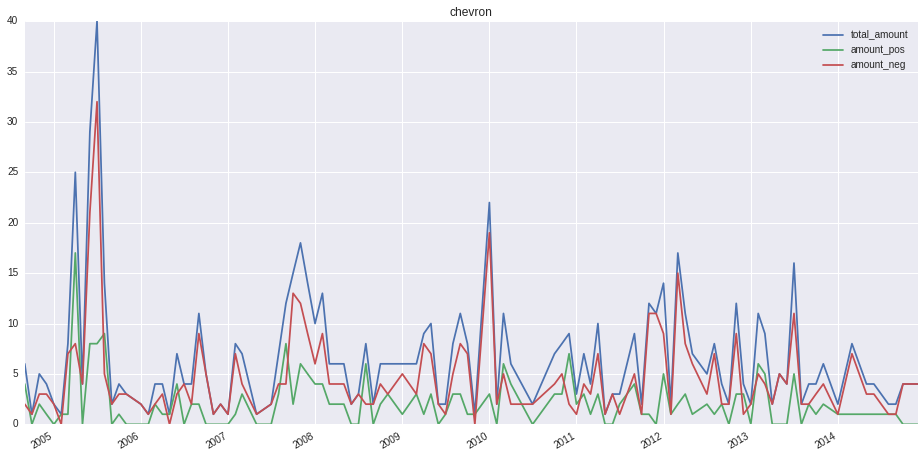

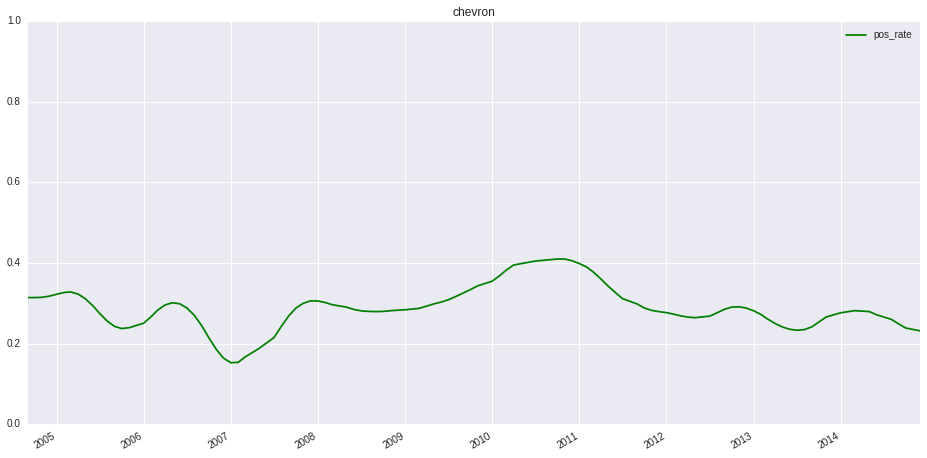

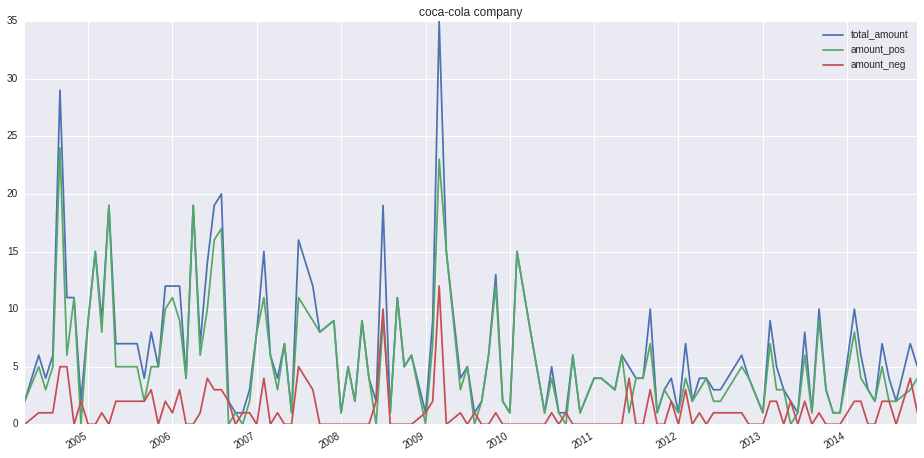

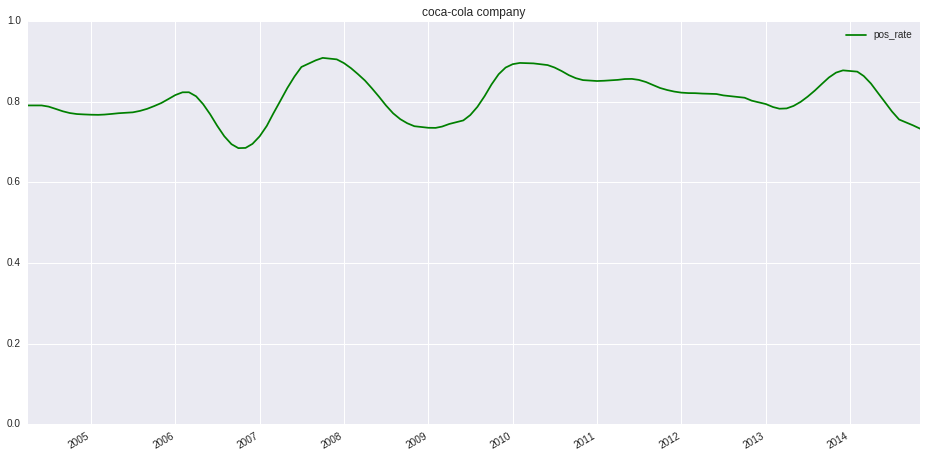

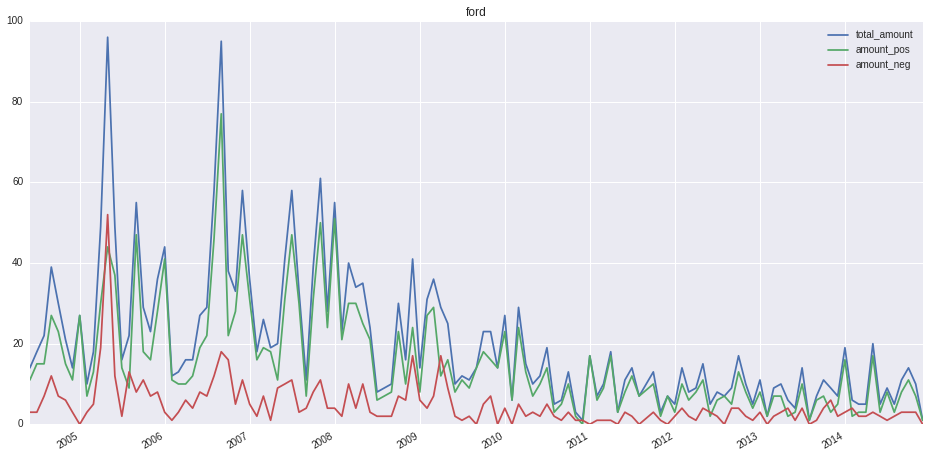

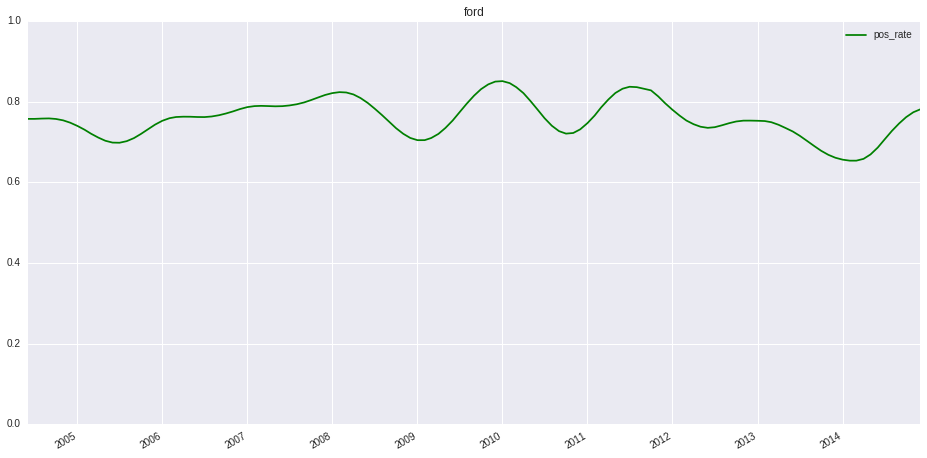

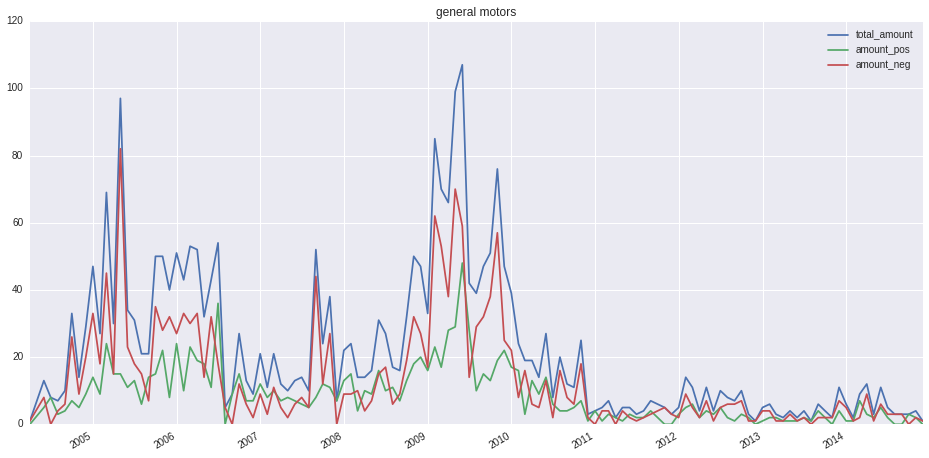

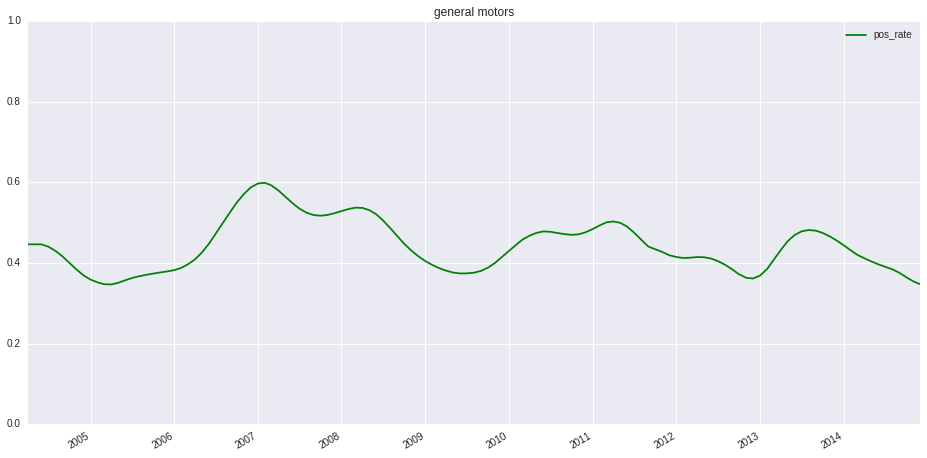

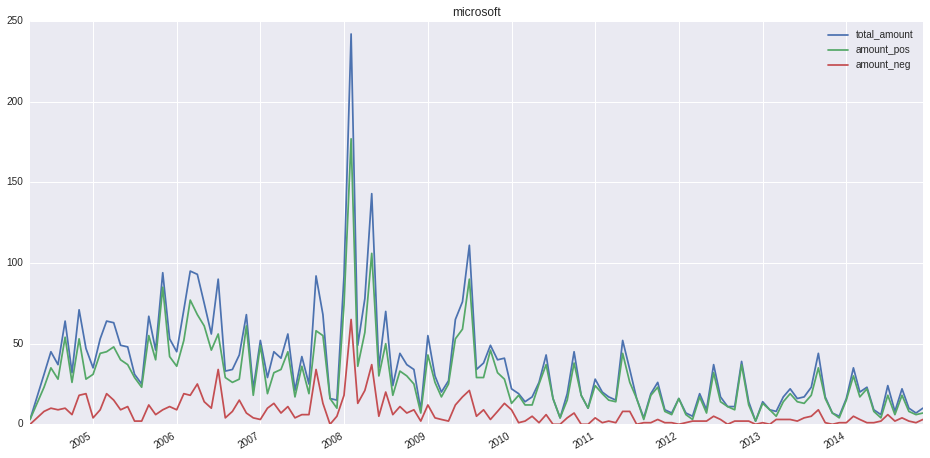

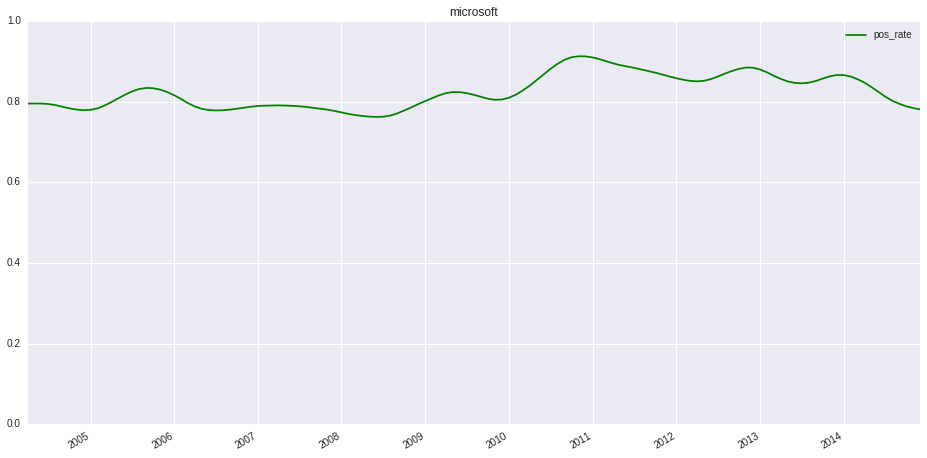

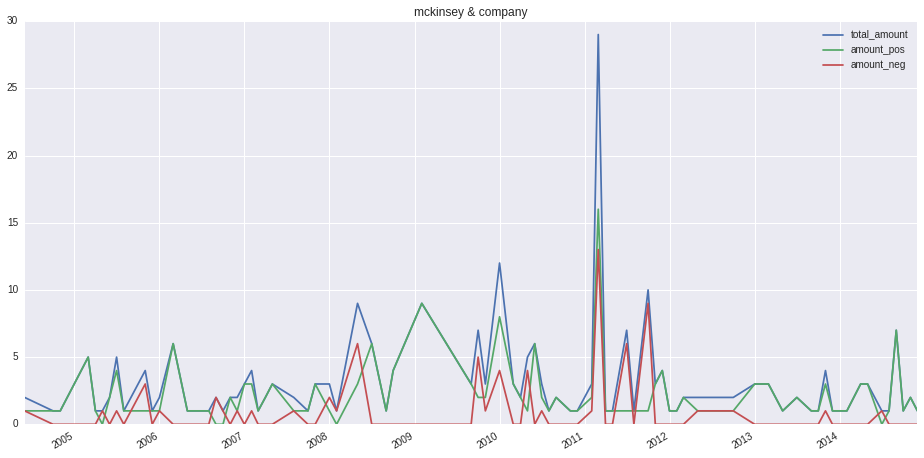

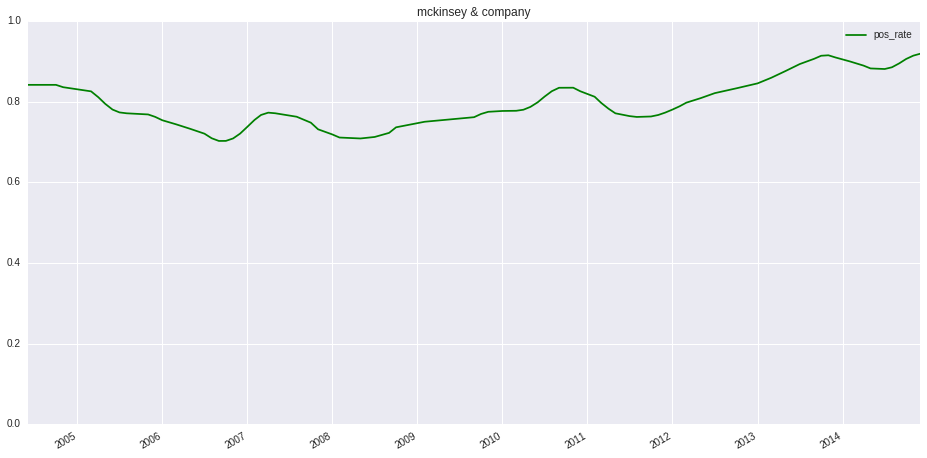

In [50]:
plot(term_list=['chevron', 'coca-cola company', 'ford', 'general motors', 'microsoft', 'mckinsey & company'], info='total', same=False)

##Fig.6 Positive rate of sentences for big companies over the period 1999 to 2014

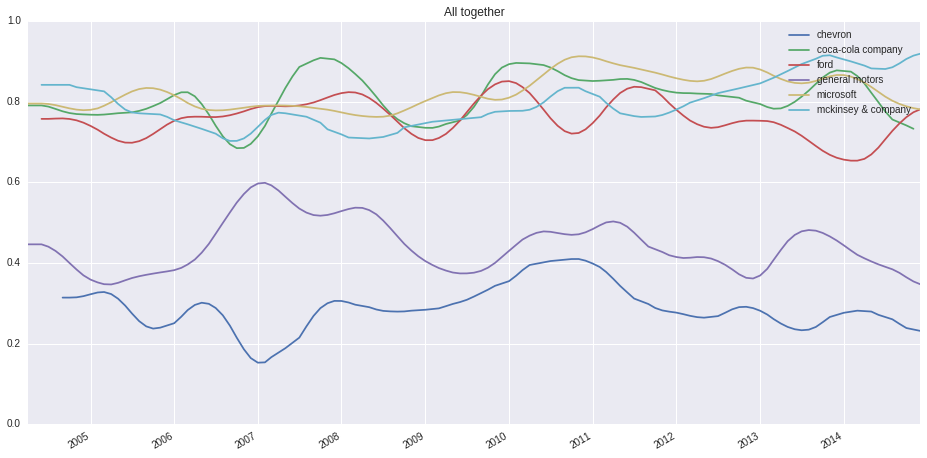

In [51]:
plot(term_list=['chevron', 'coca-cola company', 'ford', 'general motors', 'microsoft', 'mckinsey & company'], info='pos_rate', same=True)

##Fig.7 Distribution of sentences for new companies over the period 1999 to 2014

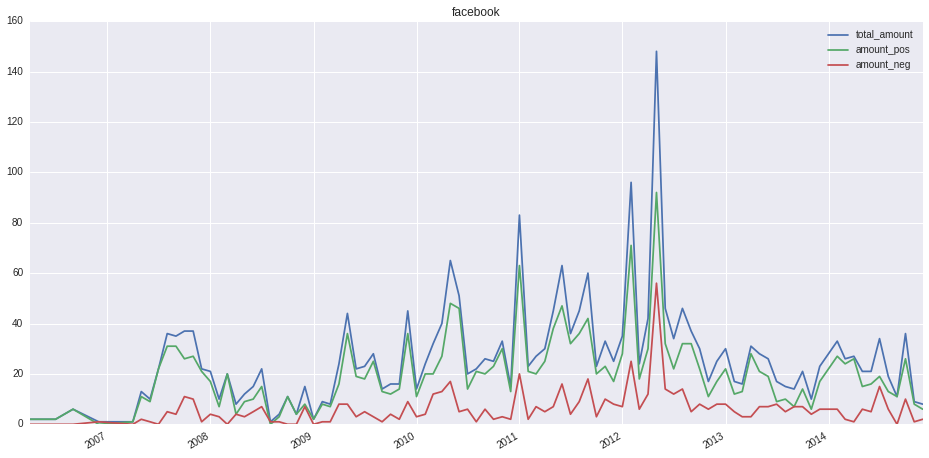

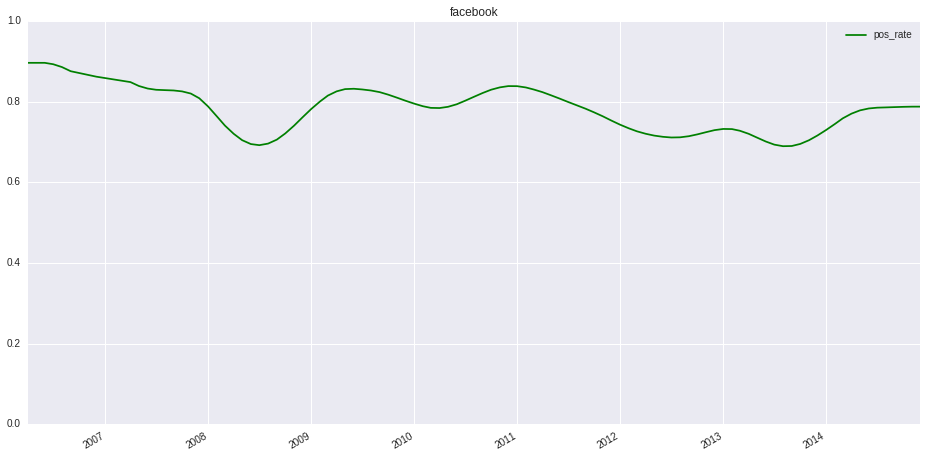

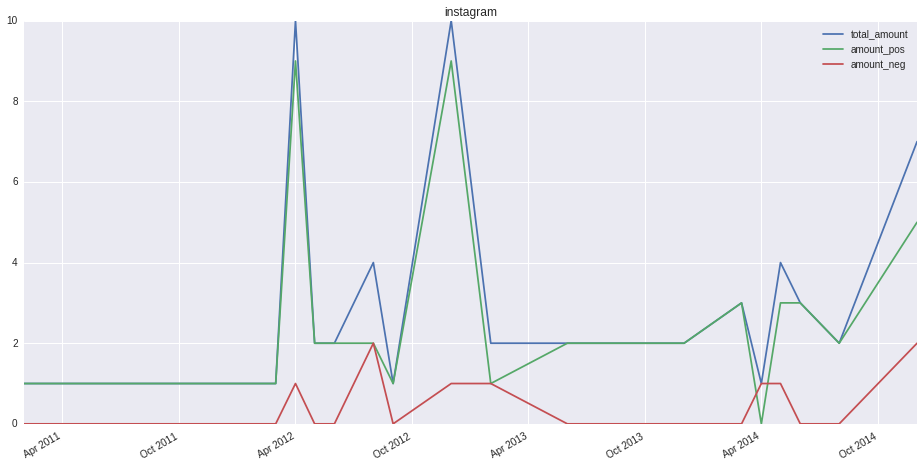

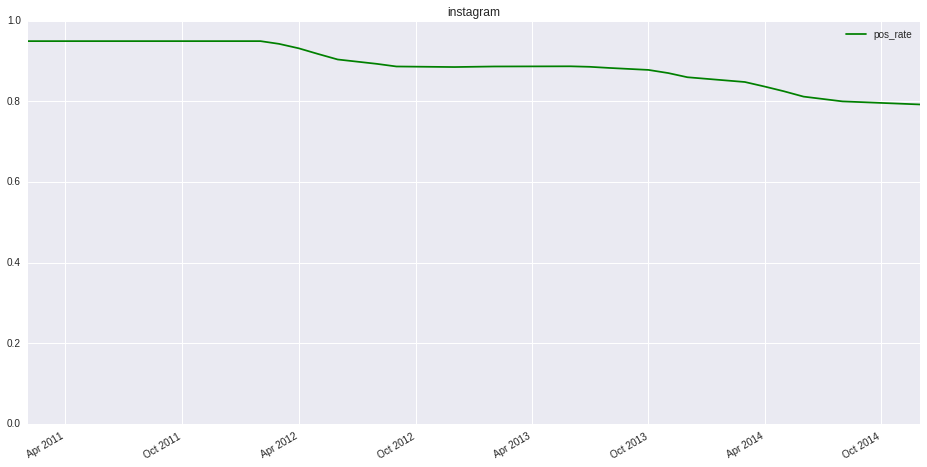

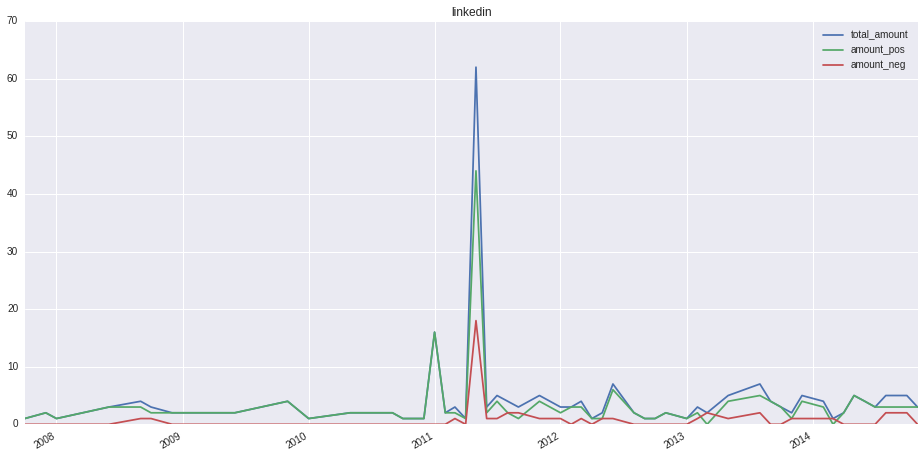

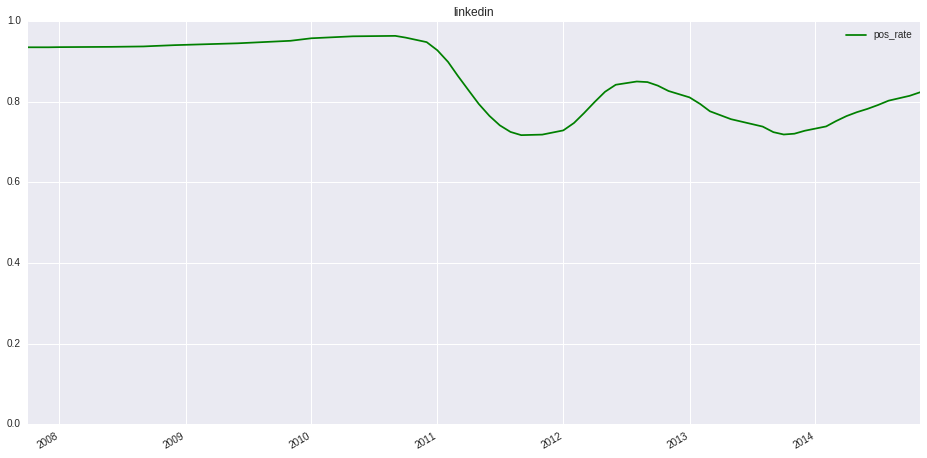

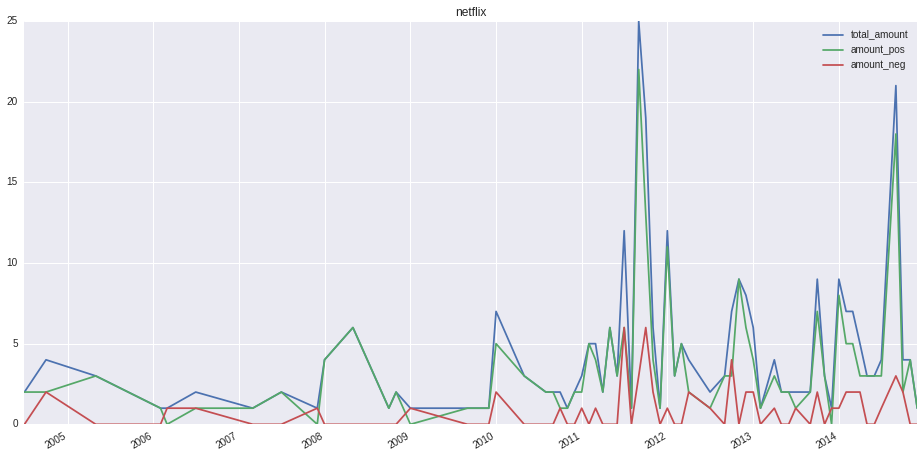

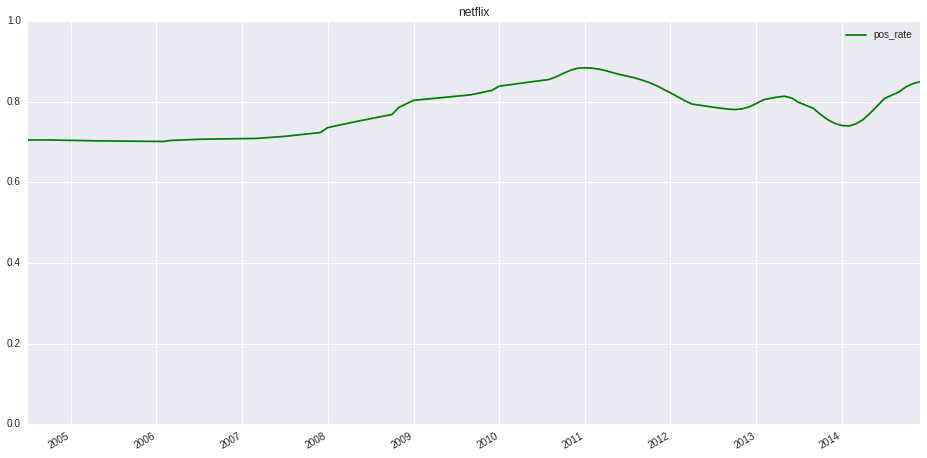

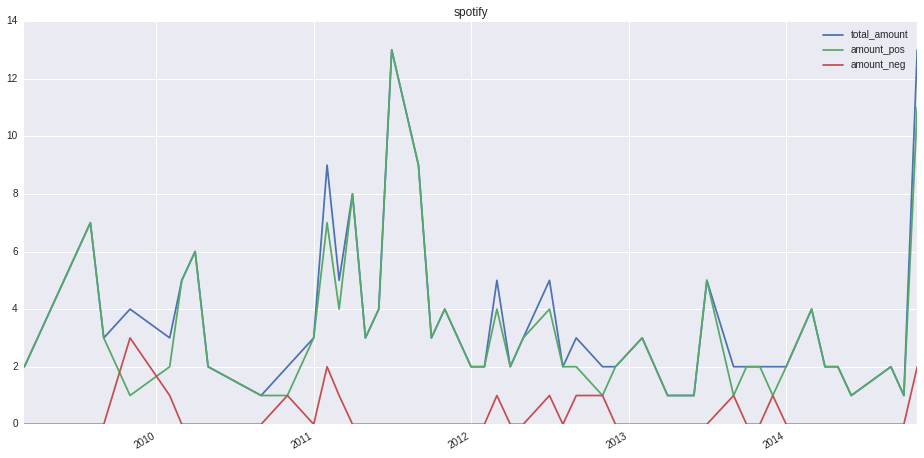

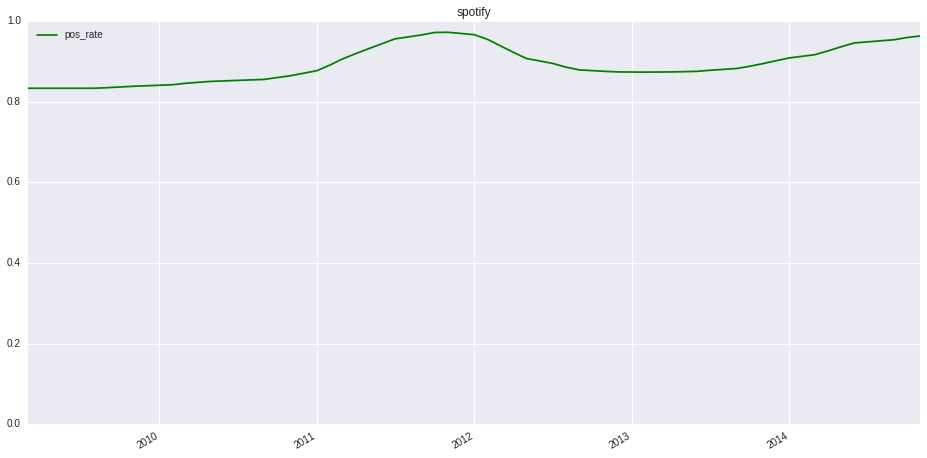

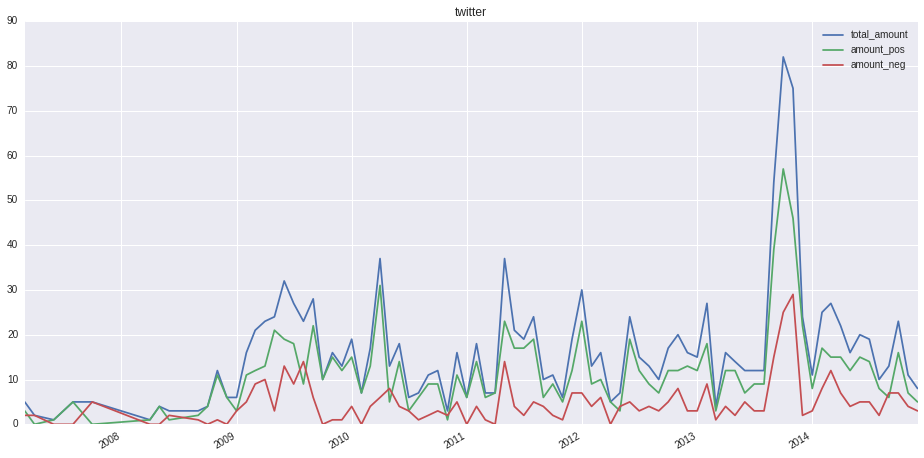

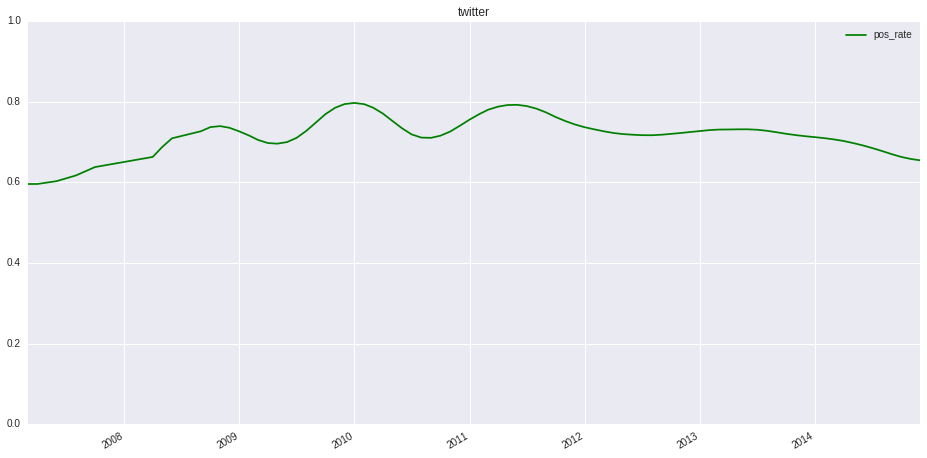

In [52]:
plot(term_list=['facebook', 'instagram', 'linkedin', 'netflix', 'spotify', 'twitter'], info='total', same=False)

##Fig.8 Positive rate of sentences for new companies over the period 1999 to 2014

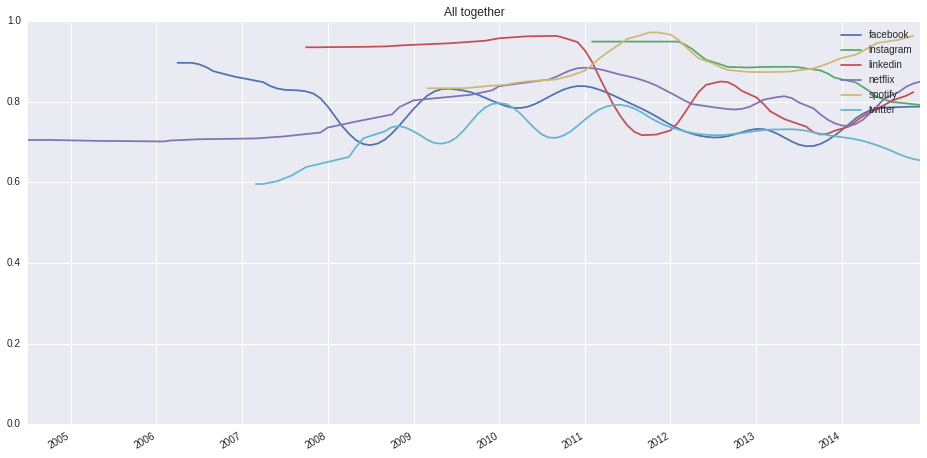

In [53]:
plot(term_list=['facebook', 'instagram', 'linkedin', 'netflix', 'spotify', 'twitter'], info='pos_rate', same=True)